## LLM Validation Performance Report

This section generates a performance report for LLM repair detection validation results.


# Statistical Analysis: Repair Patterns in Learner-AI Interaction

This notebook performs comprehensive statistical analysis of repair patterns in learner-AI dialogues, following the codebook framework.

## Analysis Framework

Based on the Codebook for Repair Patterns, we analyze:

1. **Descriptive Statistics**:
   - Mean repairs per session
   - Mean turns per dialogue
   - Mean words per turn
   - Completion rate
   - Satisfaction scores (if available)

2. **Inferential Statistics**:
   - Chi-square: Initiation (LI vs BI) × Resolution (R vs U-A vs U-P)

3. **Correlations**:
   - Repair frequency × satisfaction
   - Unresolved repairs × ease ratings
   - Turns × satisfaction

## Data Structure

- **Dialogue Files**: `W*_T*.json` - Contains turn-by-turn dialogue data
- **Repair Files**: `*_repairs.json` - Contains repair sequence annotations



In [21]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
# Try different style names for compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Create output directory for figures (relative to project root)
# When running from notebook, go up one level to project root
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    project_root = Path('..')
else:
    project_root = Path('.')
    
output_dir = project_root / 'statistical_analysis_images'
output_dir.mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"Output directory: {output_dir}")



Libraries imported successfully!
Output directory: ..\statistical_analysis_images


## 1. Data Loading and Preparation

Load all dialogue and repair files, then create a comprehensive dataset for analysis.



In [ ]:
# Load all dialogue and repair files
# Handle path correctly whether running from notebook directory or project root
if os.path.basename(os.getcwd()) == 'notebooks':
    processed_dir = Path('../data/processed')
    repairs_dir = Path('../data/repairs/production')
else:
    processed_dir = Path('data/processed')
    repairs_dir = Path('data/repairs/production')

# Load dialogue files - use new format S*_W*_T*.json
dialogue_files = sorted(processed_dir.glob('S*_W*_T*.json'))
# Also include old format W*_T*.json if any exist
old_format_files = sorted(processed_dir.glob('W*_T*.json'))
old_format_files = [f for f in old_format_files if '_repairs' not in f.name and f.name not in [d.name for d in dialogue_files]]
dialogue_files.extend(old_format_files)

# Load repair files from production folder
repair_files = sorted(repairs_dir.glob('*_repairs.json'))

print(f"Found {len(dialogue_files)} dialogue files")
print(f"Found {len(repair_files)} repair files")

# Load all dialogues
dialogues = []
for file in dialogue_files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Ensure dialogue_id exists - use filename stem if missing
        if 'dialogue_id' not in data or not data.get('dialogue_id'):
            # Use filename stem directly (S18_W1_T1 or W1_T1_S18 format)
            data['dialogue_id'] = file.stem
        dialogues.append(data)

# Load all repairs
all_repairs = []
for file in repair_files:
    with open(file, 'r', encoding='utf-8') as f:
        repairs = json.load(f)
        all_repairs.extend(repairs)

print(f"\nTotal dialogues: {len(dialogues)}")
print(f"Total repair sequences: {len(all_repairs)}")
print(f"\nSample dialogue IDs: {[d.get('dialogue_id', 'N/A') for d in dialogues[:3]]}")
print(f"Sample repair dialogue IDs: {[r.get('dialogue_id', 'N/A') for r in all_repairs[:3]]}")



Found 206 dialogue files
Found 206 repair files

Total dialogues: 206
Total repair sequences: 242

Sample dialogue IDs: ['S12_W1_T1', 'S12_W1_T2', 'S12_W2_T1']
Sample repair dialogue IDs: ['S12_W1_T1', 'S12_W1_T1', 'S12_W2_T1']


In [23]:
# Create dialogue-level dataset
dialogue_data = []

for dialogue in dialogues:
    dialogue_id = dialogue.get('dialogue_id', 'Unknown')
    student_id = dialogue.get('student_id', 'Unknown')
    turns = dialogue.get('turns', [])
    
    # Extract week and task from dialogue_id
    # Handle formats: "S18_W1_T1" or "W1_T1_S18" or "W1_T1"
    week = 'Unknown'
    task = 'Unknown'
    if dialogue_id and dialogue_id != 'Unknown':
        # Handle S*_W*_T* format (new format)
        if dialogue_id.startswith('S') and '_W' in dialogue_id:
            parts = dialogue_id.split('_')
            for i, part in enumerate(parts):
                if part.startswith('W') and len(part) > 1:
                    try:
                        week = int(part[1:])
                    except:
                        pass
                elif part.startswith('T') and len(part) > 1:
                    try:
                        task = int(part[1:])
                    except:
                        pass
        else:
            # Handle W*_T* or W*_T*_S* format (old format)
            # Extract week number (after 'W')
            week_match = dialogue_id.split('_')[0]  # "W1" -> "W1"
            if week_match.startswith('W') and len(week_match) > 1:
                try:
                    week = int(week_match[1:])
                except:
                    week = week_match[1] if len(week_match) > 1 else 'Unknown'
            
            # Extract task number (after 'T')
            if '_T' in dialogue_id:
                task_part = dialogue_id.split('_T')[1]  # "1" or "1_S18"
                task_num = task_part.split('_')[0] if '_' in task_part else task_part
                try:
                    task = int(task_num)
                except:
                    task = task_num[0] if task_num else 'Unknown'
    
    # Count repairs for this dialogue
    # Match repairs - exact match on dialogue_id
    repairs_for_dialogue = []
    
    for r in all_repairs:
        repair_dialogue_id = r.get('dialogue_id', '')
        # Direct exact match (all repair files now use S*_W*_T* format matching dialogues)
        if repair_dialogue_id == dialogue_id:
            repairs_for_dialogue.append(r)
    
    num_repairs = len(repairs_for_dialogue)
    
    # Calculate statistics
    num_turns = len(turns)
    
    # Count words per turn
    words_per_turn = []
    learner_words = []
    bot_words = []
    
    for turn in turns:
        text = turn.get('text', '')
        word_count = len(text.split())
        words_per_turn.append(word_count)
        
        if turn.get('speaker') == 'learner':
            learner_words.append(word_count)
        elif turn.get('speaker') == 'bot':
            bot_words.append(word_count)
    
    mean_words_per_turn = np.mean(words_per_turn) if words_per_turn else 0
    mean_learner_words = np.mean(learner_words) if learner_words else 0
    mean_bot_words = np.mean(bot_words) if bot_words else 0
    
    # Count repair types
    li_count = sum(1 for r in repairs_for_dialogue if r.get('initiation') == 'LI')
    bi_count = sum(1 for r in repairs_for_dialogue if r.get('initiation') == 'BI')
    r_count = sum(1 for r in repairs_for_dialogue if r.get('resolution') == 'R')
    ua_count = sum(1 for r in repairs_for_dialogue if r.get('resolution') == 'U-A')
    up_count = sum(1 for r in repairs_for_dialogue if r.get('resolution') == 'U-P')
    
    dialogue_data.append({
        'dialogue_id': dialogue_id,
        'student_id': student_id,
        'week': week,
        'task': task,
        'num_turns': num_turns,
        'num_repairs': num_repairs,
        'mean_words_per_turn': mean_words_per_turn,
        'mean_learner_words': mean_learner_words,
        'mean_bot_words': mean_bot_words,
        'li_count': li_count,
        'bi_count': bi_count,
        'r_count': r_count,
        'ua_count': ua_count,
        'up_count': up_count,
        'unresolved_count': ua_count + up_count
    })

# Create DataFrame
df_dialogues = pd.DataFrame(dialogue_data)
print("\nDialogue-level dataset created:")
print(df_dialogues.head())
print(f"\nDataset shape: {df_dialogues.shape}")




Dialogue-level dataset created:
  dialogue_id  student_id  week  task  num_turns  num_repairs  \
0   S12_W1_T1          12     1     1         22            2   
1   S12_W1_T2          12     1     2         28            0   
2   S12_W2_T1          12     2     1         46            7   
3   S12_W2_T2          12     2     2         36            1   
4   S12_W2_T3          12     2     3         44            4   

   mean_words_per_turn  mean_learner_words  mean_bot_words  li_count  \
0            15.727273            9.909091       21.545455         0   
1            19.535714           11.357143       27.714286         0   
2            17.782609            8.652174       26.913043         7   
3            20.805556           12.722222       28.888889         1   
4            20.022727           10.590909       29.454545         1   

   bi_count  r_count  ua_count  up_count  unresolved_count  
0         2        2         0         0                 0  
1         0        0 

In [24]:
# Create repair-level dataset
repair_data = []

for repair in all_repairs:
    repair_data.append({
        'dialogue_id': repair.get('dialogue_id', 'Unknown'),
        'repair_id': repair.get('repair_id', 0),
        'initiation': repair.get('initiation', 'Unknown'),
        'resolution': repair.get('resolution', 'Unknown'),
        'trigger': repair.get('trigger', 'Unknown'),
        'num_turns_in_repair': len(repair.get('turn_indices', []))
    })

df_repairs = pd.DataFrame(repair_data)
print("\nRepair-level dataset created:")
print(df_repairs.head())
print(f"\nDataset shape: {df_repairs.shape}")




Repair-level dataset created:
  dialogue_id  repair_id initiation resolution  \
0   S12_W1_T1          1         BI          R   
1   S12_W1_T1          2         BI          R   
2   S12_W2_T1          1         LI          R   
3   S12_W2_T1          2         LI          R   
4   S12_W2_T1          3         LI          R   

                                             trigger  num_turns_in_repair  
0  pronunciation/ASR – misrecognition of learner ...                    2  
1  pronunciation/ASR – misrecognition of learner ...                    2  
2  learner did not understand bot's previous utte...                    3  
3  unclear phrasing – learner's awkward questions...                    5  
4   bot omission – bot did not provide specific time                    3  

Dataset shape: (242, 6)


## 2. Descriptive Statistics

Calculate key descriptive statistics for the dataset.



In [16]:
# Calculate descriptive statistics
descriptives = {
    'Mean Repairs per Session': df_dialogues['num_repairs'].mean(),
    'Median Repairs per Session': df_dialogues['num_repairs'].median(),
    'SD Repairs per Session': df_dialogues['num_repairs'].std(),
    'Min Repairs': df_dialogues['num_repairs'].min(),
    'Max Repairs': df_dialogues['num_repairs'].max(),
    'Mean Turns per Dialogue': df_dialogues['num_turns'].mean(),
    'Median Turns per Dialogue': df_dialogues['num_turns'].median(),
    'SD Turns per Dialogue': df_dialogues['num_turns'].std(),
    'Mean Words per Turn': df_dialogues['mean_words_per_turn'].mean(),
    'Mean Learner Words per Turn': df_dialogues['mean_learner_words'].mean(),
    'Mean Bot Words per Turn': df_dialogues['mean_bot_words'].mean(),
    'Total Dialogues': len(df_dialogues),
    'Total Repair Sequences': len(df_repairs)
}

# Create summary DataFrame
df_descriptives = pd.DataFrame([descriptives]).T
df_descriptives.columns = ['Value']
df_descriptives = df_descriptives.round(2)

print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
print(df_descriptives)

# Save to CSV
df_descriptives.to_csv(output_dir / 'descriptive_statistics.csv')
print(f"\nSaved to: {output_dir / 'descriptive_statistics.csv'}")



DESCRIPTIVE STATISTICS
                              Value
Mean Repairs per Session       1.17
Median Repairs per Session     0.00
SD Repairs per Session         1.69
Min Repairs                    0.00
Max Repairs                    8.00
Mean Turns per Dialogue       44.62
Median Turns per Dialogue     41.00
SD Turns per Dialogue         25.09
Mean Words per Turn           23.11
Mean Learner Words per Turn   14.60
Mean Bot Words per Turn       30.85
Total Dialogues              206.00
Total Repair Sequences       242.00

Saved to: ..\statistical_analysis_images\descriptive_statistics.csv


In [17]:
# Statistics by Week
print("\n" + "="*60)
print("STATISTICS BY WEEK")
print("="*60)

weekly_stats = df_dialogues.groupby('week').agg({
    'num_repairs': ['mean', 'std', 'count'],
    'num_turns': ['mean', 'std'],
    'mean_words_per_turn': 'mean'
}).round(2)

print(weekly_stats)

# Save to CSV
weekly_stats.to_csv(output_dir / 'weekly_statistics.csv')
print(f"\nSaved to: {output_dir / 'weekly_statistics.csv'}")




STATISTICS BY WEEK
     num_repairs             num_turns        mean_words_per_turn
            mean   std count      mean    std                mean
week                                                             
1           1.58  2.13    53     46.19  30.40               21.64
2           1.15  1.53    52     48.83  24.56               20.89
3           1.25  1.74    53     41.34  20.88               22.85
4           0.67  1.06    48     41.96  23.36               27.41

Saved to: ..\statistical_analysis_images\weekly_statistics.csv


In [7]:
# Statistics by Student
print("\n" + "="*60)
print("STATISTICS BY STUDENT")
print("="*60)

student_stats = df_dialogues.groupby('student_id').agg({
    'num_repairs': ['mean', 'std', 'sum', 'count'],
    'num_turns': ['mean', 'std'],
    'mean_words_per_turn': 'mean'
}).round(2)

print(student_stats)

# Save to CSV
student_stats.to_csv(output_dir / 'student_statistics.csv')
print(f"\nSaved to: {output_dir / 'student_statistics.csv'}")




STATISTICS BY STUDENT
           num_repairs                 num_turns        mean_words_per_turn
                  mean   std sum count      mean    std                mean
student_id                                                                 
1                 0.83  1.03  10    12     49.58  28.67               25.37
2                 0.88  1.36   7     8     23.12  14.93               24.89
5                 1.50  1.51  12     8     49.38  23.32               25.83
7                 1.78  1.86  16     9     27.67  22.85               29.19
8                 0.45  1.04   5    11     36.55  10.77               18.41
9                 3.00  2.78  24     8     70.00  39.56               15.70
12                1.78  2.39  16     9     34.67   8.49               21.85
13                0.67  1.12   6     9     62.00  21.98               22.06
14                0.17  0.39   2    12     45.58  19.13               19.81
16                2.67  2.35  32    12     63.17  26.09          

## 3. Visualization: Descriptive Statistics

Create visualizations for key descriptive statistics.



Saved: ..\statistical_analysis_images\01_descriptive_statistics.png


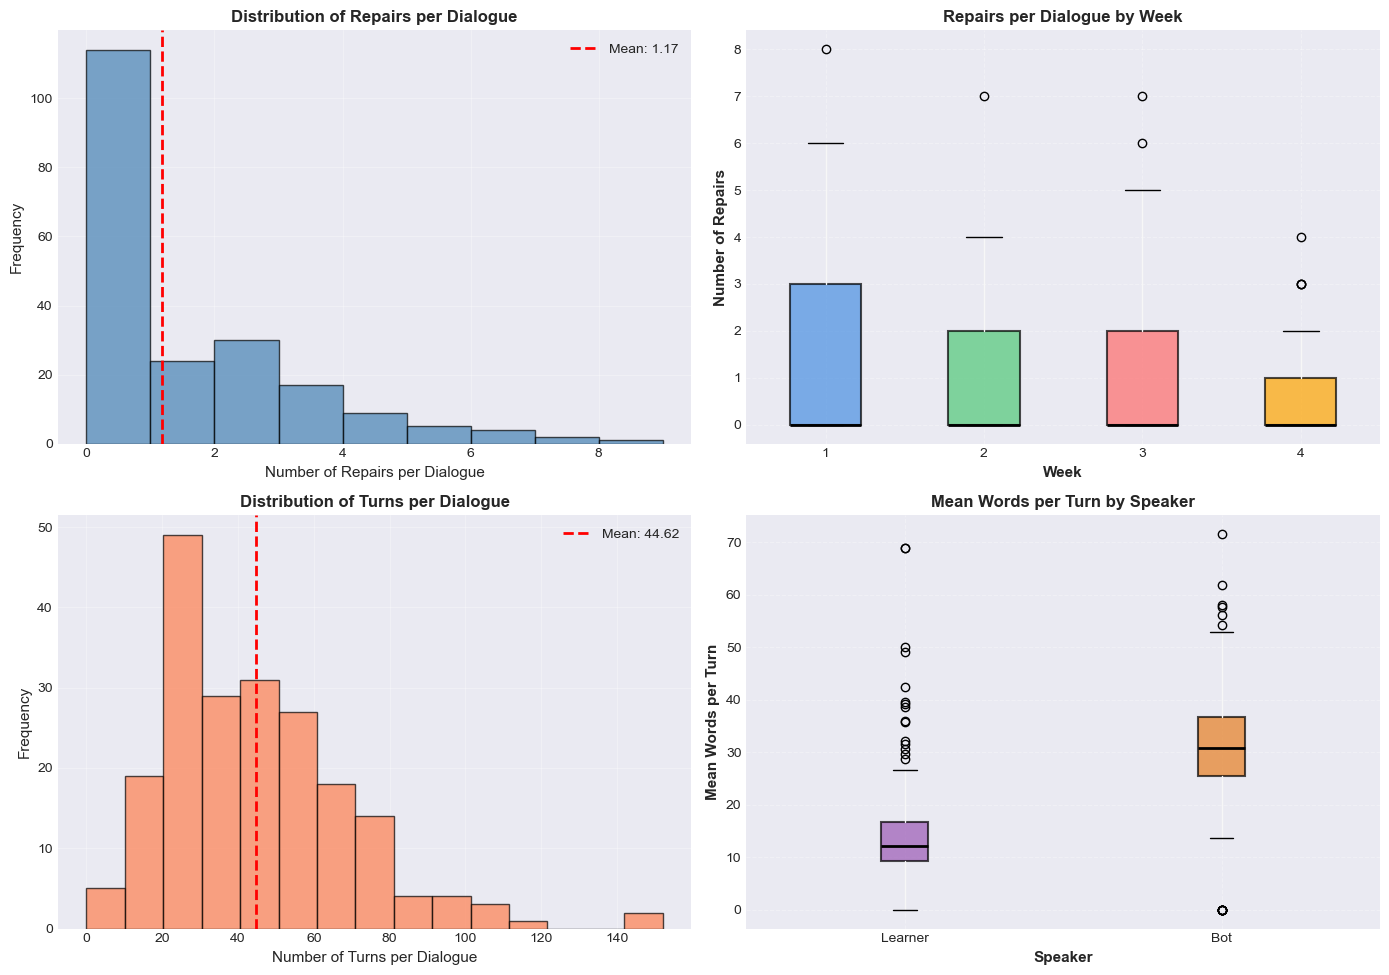

In [8]:
# Figure 1: Distribution of Repairs per Dialogue
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Descriptive Statistics: Repair Patterns', fontsize=16, fontweight='bold')

# 1. Histogram of repairs per dialogue
axes[0, 0].hist(df_dialogues['num_repairs'], bins=range(0, df_dialogues['num_repairs'].max()+2), 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df_dialogues['num_repairs'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df_dialogues["num_repairs"].mean():.2f}')
axes[0, 0].set_xlabel('Number of Repairs per Dialogue', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Repairs per Dialogue', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot of repairs by week (improved colors and visibility)
bp1 = df_dialogues.boxplot(column='num_repairs', by='week', ax=axes[0, 1], 
                           patch_artist=True, return_type='dict')
# Color the boxes with distinct, vibrant colors
colors_week = ['#4A90E2', '#50C878', '#FF6B6B', '#FFA500']  # Blue, Green, Red, Orange
for patch, color in zip(bp1['num_repairs']['boxes'], colors_week[:len(bp1['num_repairs']['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)
# Style the median lines
for median in bp1['num_repairs']['medians']:
    median.set_color('black')
    median.set_linewidth(2)
axes[0, 1].set_xlabel('Week', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Number of Repairs', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Repairs per Dialogue by Week', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, linestyle='--')
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=0)
# Remove the default "by week" title
axes[0, 1].get_figure().suptitle('')

# 3. Distribution of turns per dialogue
axes[1, 0].hist(df_dialogues['num_turns'], bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].axvline(df_dialogues['num_turns'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df_dialogues["num_turns"].mean():.2f}')
axes[1, 0].set_xlabel('Number of Turns per Dialogue', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Turns per Dialogue', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Mean words per turn by speaker (improved colors and visibility)
speaker_words = pd.DataFrame({
    'Learner': df_dialogues['mean_learner_words'],
    'Bot': df_dialogues['mean_bot_words']
})
bp2 = speaker_words.boxplot(ax=axes[1, 1], patch_artist=True, return_type='dict')
# Color the boxes with distinct colors
colors_speaker = ['#9B59B6', '#E67E22']  # Purple for Learner, Orange for Bot
for patch, color in zip(bp2['boxes'], colors_speaker):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)
# Style the median lines
for median in bp2['medians']:
    median.set_color('black')
    median.set_linewidth(2)
axes[1, 1].set_ylabel('Mean Words per Turn', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Speaker', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Mean Words per Turn by Speaker', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(output_dir / '01_descriptive_statistics.png', dpi=300, bbox_inches='tight')
print(f"Saved: {output_dir / '01_descriptive_statistics.png'}")
plt.show()



In [ ]:
# Create contingency table: Initiation × Resolution
contingency_table = pd.crosstab(df_repairs['initiation'], df_repairs['resolution'], 
                                margins=True, margins_name='Total')

print("="*60)
print("CONTINGENCY TABLE: Initiation × Resolution")
print("="*60)
print(contingency_table)

# Save to CSV
contingency_table.to_csv(output_dir / 'contingency_table_initiation_resolution.csv')
print(f"\nSaved to: {output_dir / 'contingency_table_initiation_resolution.csv'}")

# Calculate percentages
contingency_pct = pd.crosstab(df_repairs['initiation'], df_repairs['resolution'], 
                               normalize='index') * 100
print("\n" + "="*60)
print("PERCENTAGES (Row-wise)")
print("="*60)
print(contingency_pct.round(2))



CONTINGENCY TABLE: Initiation × Resolution
resolution    R  U-A  Total
initiation                 
BI           60    0     60
LI          179    3    182
Total       239    3    242

Saved to: ..\statistical_analysis_images\contingency_table_initiation_resolution.csv

PERCENTAGES (Row-wise)
resolution       R   U-A
initiation              
BI          100.00  0.00
LI           98.35  1.65


In [18]:
# Chi-square test: Initiation × Resolution
# Remove margins for statistical test
contingency_for_test = pd.crosstab(df_repairs['initiation'], df_repairs['resolution'])

print("="*60)
print("CHI-SQUARE TEST: Initiation × Resolution")
print("="*60)

# Check if we have enough categories for chi-square test
# Need at least 2x2 table
if contingency_for_test.shape[0] < 2 or contingency_for_test.shape[1] < 2:
    print("WARNING: Contingency table is too small for chi-square test.")
    print("Need at least 2 categories in both dimensions.")
    print(f"Current table shape: {contingency_for_test.shape}")
    print("\nTable:")
    print(contingency_for_test)
    
    # Set default values if test cannot be performed
    chi2 = 0.0
    p_value = 1.0
    dof = 0
    expected = contingency_for_test.values
    print("\nChi-square test cannot be performed with current data structure.")
else:
    chi2, p_value, dof, expected = chi2_contingency(contingency_for_test)
    
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p_value:.4f}")
    print(f"Expected frequencies:\n{expected}")
    
    if p_value < 0.05:
        print("\n✓ Significant association between Initiation and Resolution (p < 0.05)")
    else:
        print("\n✗ No significant association between Initiation and Resolution (p >= 0.05)")

# Save results - convert NumPy types to native Python types for JSON serialization
chi2_results = {
    'chi2_statistic': float(chi2) if hasattr(chi2, 'item') else float(chi2),
    'p_value': float(p_value) if hasattr(p_value, 'item') else float(p_value),
    'degrees_of_freedom': int(dof) if hasattr(dof, 'item') else int(dof),
    'significant': bool(p_value < 0.05) if dof > 0 else False,
    'test_performed': bool(dof > 0)
}

with open(output_dir / 'chi2_results.json', 'w') as f:
    json.dump(chi2_results, f, indent=2)

print(f"\nSaved to: {output_dir / 'chi2_results.json'}")



CHI-SQUARE TEST: Initiation × Resolution
Chi-square statistic: 0.1076
Degrees of freedom: 1
P-value: 0.7429
Expected frequencies:
[[ 59.25619835   0.74380165]
 [179.74380165   2.25619835]]

✗ No significant association between Initiation and Resolution (p >= 0.05)

Saved to: ..\statistical_analysis_images\chi2_results.json


Saved: ..\statistical_analysis_images\02_initiation_resolution_patterns.png


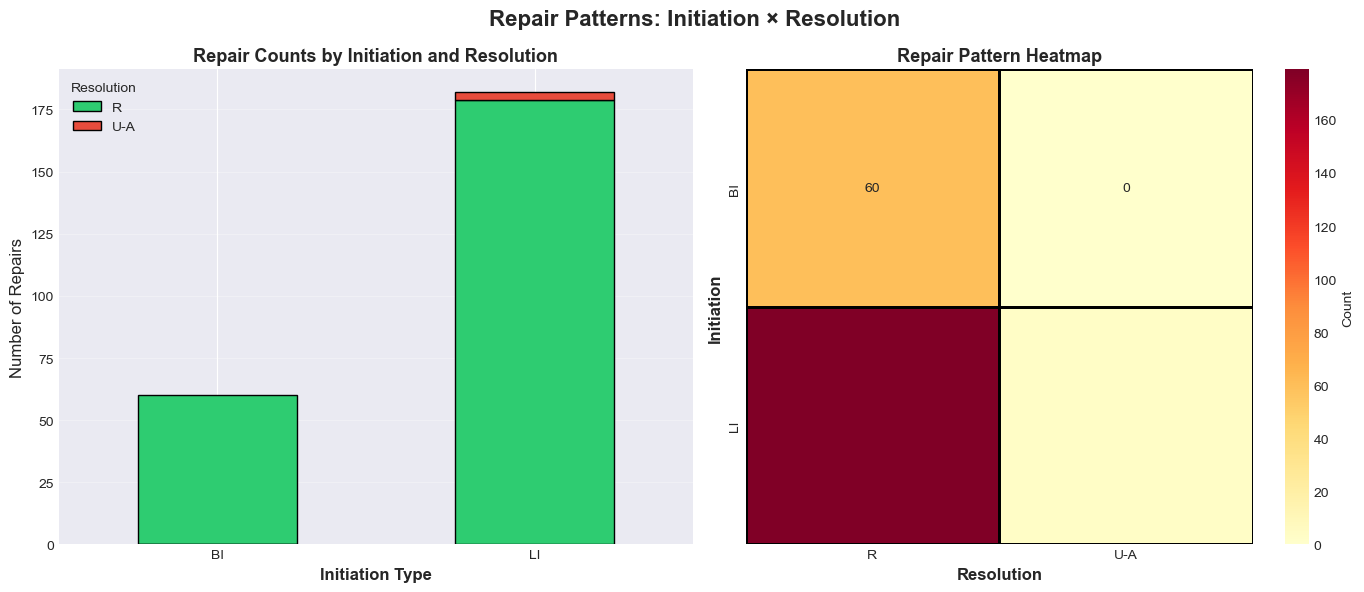

In [19]:
# Visualization: Initiation × Resolution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Repair Patterns: Initiation × Resolution', fontsize=16, fontweight='bold')

# 1. Stacked bar chart
contingency_for_plot = pd.crosstab(df_repairs['initiation'], df_repairs['resolution'])

# Handle case where we might have only one resolution category
colors_map = {'R': '#2ecc71', 'U-A': '#e74c3c', 'U-P': '#f39c12'}
available_colors = [colors_map.get(col, '#95a5a6') for col in contingency_for_plot.columns]

contingency_for_plot.plot(kind='bar', stacked=True, ax=axes[0], 
                          color=available_colors[:len(contingency_for_plot.columns)], 
                          edgecolor='black')
axes[0].set_xlabel('Initiation Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Repairs', fontsize=12)
axes[0].set_title('Repair Counts by Initiation and Resolution', fontsize=13, fontweight='bold')
axes[0].legend(title='Resolution', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Heatmap
sns.heatmap(contingency_for_plot, annot=True, fmt='d', cmap='YlOrRd', 
            ax=axes[1], cbar_kws={'label': 'Count'}, linewidths=1, linecolor='black')
axes[1].set_xlabel('Resolution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Initiation', fontsize=12, fontweight='bold')
axes[1].set_title('Repair Pattern Heatmap', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / '02_initiation_resolution_patterns.png', dpi=300, bbox_inches='tight')
print(f"Saved: {output_dir / '02_initiation_resolution_patterns.png'}")
plt.show()



## 5. Trigger Type Analysis

Analyze the distribution of repair triggers (what caused the trouble).



In [20]:
# Analyze trigger types
trigger_counts = df_repairs['trigger'].value_counts()

print("="*60)
print("REPAIR TRIGGERS (Top 15)")
print("="*60)
print(trigger_counts.head(15))

# Categorize triggers
def categorize_trigger(trigger):
    trigger_lower = str(trigger).lower()
    if 'asr' in trigger_lower or 'pronunciation' in trigger_lower or 'misrecognition' in trigger_lower:
        return 'ASR/Pronunciation'
    elif 'vocabulary' in trigger_lower or 'lexical' in trigger_lower:
        return 'Vocabulary/Lexical'
    elif 'comprehension' in trigger_lower or 'understand' in trigger_lower:
        return 'Comprehension'
    elif 'bot misunderstanding' in trigger_lower or 'bot' in trigger_lower:
        return 'Bot Misunderstanding'
    elif 'self-correction' in trigger_lower or 'self' in trigger_lower:
        return 'Self-Correction'
    elif 'unclear' in trigger_lower or 'fragmented' in trigger_lower:
        return 'Unclear Phrasing'
    elif 'context' in trigger_lower or 'contextual' in trigger_lower:
        return 'Contextual Error'
    else:
        return 'Other'

df_repairs['trigger_category'] = df_repairs['trigger'].apply(categorize_trigger)
trigger_category_counts = df_repairs['trigger_category'].value_counts()

print("\n" + "="*60)
print("TRIGGER CATEGORIES")
print("="*60)
print(trigger_category_counts)

# Save to CSV
trigger_category_counts.to_csv(output_dir / 'trigger_categories.csv')
print(f"\nSaved to: {output_dir / 'trigger_categories.csv'}")



REPAIR TRIGGERS (Top 15)
trigger
pronunciation/ASR – misrecognition of learner speech                27
self-correction – learner corrects own previous utterance           23
vocabulary – learner did not understand bot's question              16
vocabulary – learner did not understand bot's explanation            5
clarification request – learner asks for repetition                  2
vocabulary – learner did not understand bot's previous statement     2
vocabulary – learner did not understand explanation                  2
vocabulary – learner did not understand 'proof of address'           2
pronunciation/ASR – 'whitelist' misheard as 'wine list'              2
bot misunderstanding – incorrect item added to order                 2
vocabulary – did not understand 'character for this elaboration'     2
self-correction – learner corrects phone number                      2
vocabulary – learner unsure about milk content in 'flat white'       2
self-correction – learner requests to repeat

Saved: ..\statistical_analysis_images\03_trigger_analysis.png


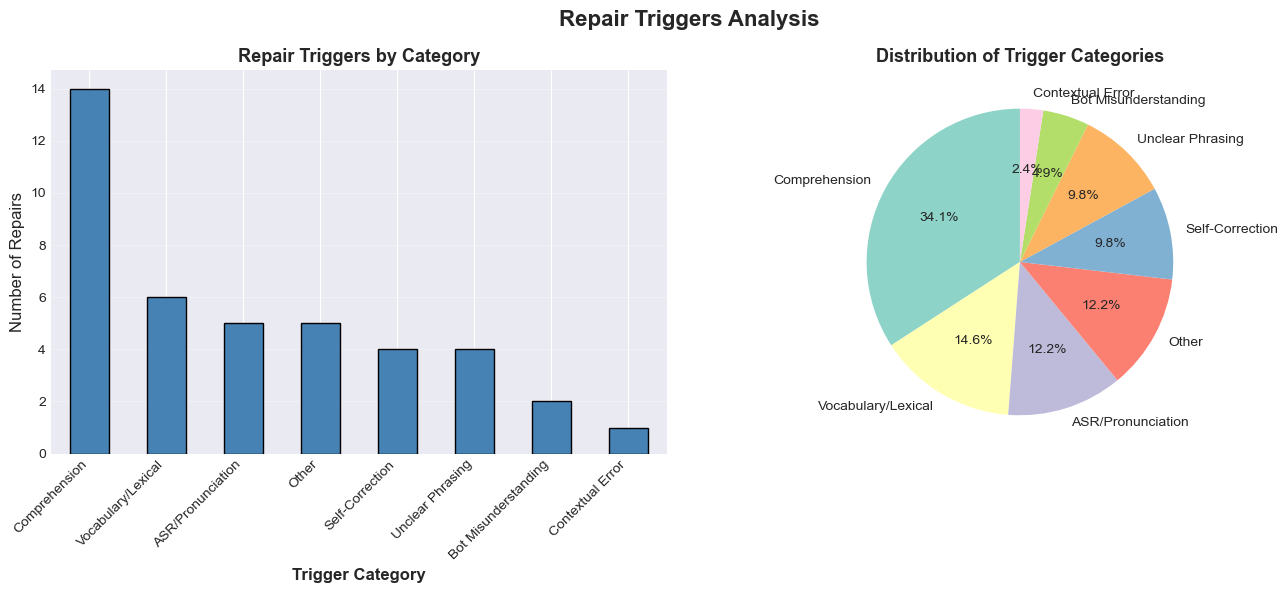

In [ ]:
# Visualization: Trigger categories
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Repair Triggers Analysis', fontsize=16, fontweight='bold')

# 1. Bar chart of trigger categories
trigger_category_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Trigger Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Repairs', fontsize=12)
axes[0].set_title('Repair Triggers by Category', fontsize=13, fontweight='bold')
# Set rotation and horizontal alignment for x-axis labels
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Pie chart
colors = plt.cm.Set3(range(len(trigger_category_counts)))
axes[1].pie(trigger_category_counts.values, labels=trigger_category_counts.index, 
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 10})
axes[1].set_title('Distribution of Trigger Categories', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / '03_trigger_analysis.png', dpi=300, bbox_inches='tight')
print(f"Saved: {output_dir / '03_trigger_analysis.png'}")
plt.show()



## 6. Correlation Analysis

Note: Satisfaction scores and ease ratings are not available in the current dataset. 
This section provides the framework for when such data becomes available.

For now, we analyze correlations between available variables:
- Repair frequency × Number of turns
- Unresolved repairs × Number of turns
- Repair frequency × Mean words per turn



In [25]:
# Calculate correlations
correlation_vars = ['num_repairs', 'num_turns', 'mean_words_per_turn', 'unresolved_count']
correlation_matrix = df_dialogues[correlation_vars].corr()

print("="*60)
print("CORRELATION MATRIX")
print("="*60)
print(correlation_matrix.round(3))

# Save to CSV
correlation_matrix.to_csv(output_dir / 'correlation_matrix.csv')
print(f"\nSaved to: {output_dir / 'correlation_matrix.csv'}")

# Calculate specific correlations
corr_repairs_turns = df_dialogues['num_repairs'].corr(df_dialogues['num_turns'])
corr_repairs_words = df_dialogues['num_repairs'].corr(df_dialogues['mean_words_per_turn'])
corr_unresolved_turns = df_dialogues['unresolved_count'].corr(df_dialogues['num_turns'])

print("\n" + "="*60)
print("KEY CORRELATIONS")
print("="*60)
print(f"Repair Frequency × Number of Turns: r = {corr_repairs_turns:.3f}")
print(f"Repair Frequency × Mean Words per Turn: r = {corr_repairs_words:.3f}")
print(f"Unresolved Repairs × Number of Turns: r = {corr_unresolved_turns:.3f}")

# Statistical significance
from scipy.stats import pearsonr

r1, p1 = pearsonr(df_dialogues['num_repairs'], df_dialogues['num_turns'])
r2, p2 = pearsonr(df_dialogues['num_repairs'], df_dialogues['mean_words_per_turn'])
r3, p3 = pearsonr(df_dialogues['unresolved_count'], df_dialogues['num_turns'])

print("\nStatistical Significance:")
print(f"Repairs × Turns: r={r1:.3f}, p={p1:.3f} {'*' if p1 < 0.05 else ''}")
print(f"Repairs × Words: r={r2:.3f}, p={p2:.3f} {'*' if p2 < 0.05 else ''}")
print(f"Unresolved × Turns: r={r3:.3f}, p={p3:.3f} {'*' if p3 < 0.05 else ''}")
print("* p < 0.05")



CORRELATION MATRIX
                     num_repairs  num_turns  mean_words_per_turn  \
num_repairs                1.000      0.365               -0.042   
num_turns                  0.365      1.000               -0.036   
mean_words_per_turn       -0.042     -0.036                1.000   
unresolved_count           0.275      0.088               -0.119   

                     unresolved_count  
num_repairs                     0.275  
num_turns                       0.088  
mean_words_per_turn            -0.119  
unresolved_count                1.000  

Saved to: ..\statistical_analysis_images\correlation_matrix.csv

KEY CORRELATIONS
Repair Frequency × Number of Turns: r = 0.365
Repair Frequency × Mean Words per Turn: r = -0.042
Unresolved Repairs × Number of Turns: r = 0.088

Statistical Significance:
Repairs × Turns: r=0.365, p=0.000 *
Repairs × Words: r=-0.042, p=0.550 
Unresolved × Turns: r=0.088, p=0.210 
* p < 0.05


Saved: ..\statistical_analysis_images\04_correlation_analysis.png


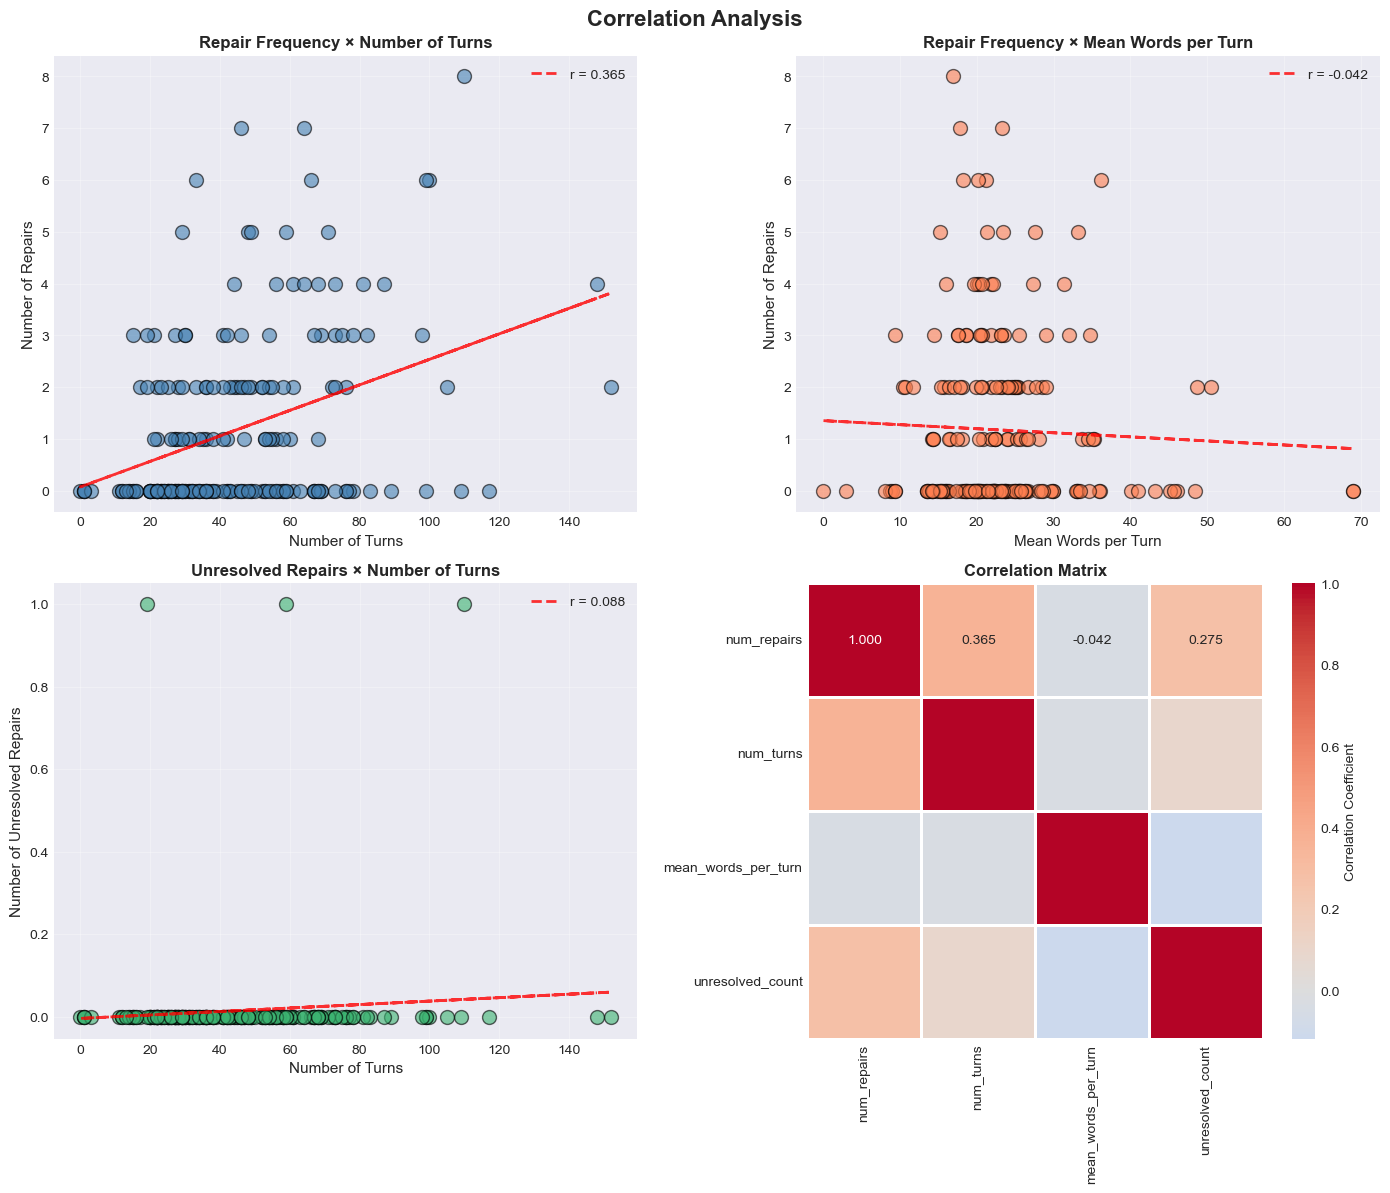

In [26]:
# Visualization: Correlation plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold')

# 1. Repair frequency × Number of turns
axes[0, 0].scatter(df_dialogues['num_turns'], df_dialogues['num_repairs'], 
                   alpha=0.6, s=100, color='steelblue', edgecolors='black')
z = np.polyfit(df_dialogues['num_turns'], df_dialogues['num_repairs'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_dialogues['num_turns'], p(df_dialogues['num_turns']), 
                "r--", alpha=0.8, linewidth=2, label=f'r = {corr_repairs_turns:.3f}')
axes[0, 0].set_xlabel('Number of Turns', fontsize=11)
axes[0, 0].set_ylabel('Number of Repairs', fontsize=11)
axes[0, 0].set_title('Repair Frequency × Number of Turns', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Repair frequency × Mean words per turn
axes[0, 1].scatter(df_dialogues['mean_words_per_turn'], df_dialogues['num_repairs'], 
                  alpha=0.6, s=100, color='coral', edgecolors='black')
z = np.polyfit(df_dialogues['mean_words_per_turn'], df_dialogues['num_repairs'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df_dialogues['mean_words_per_turn'], p(df_dialogues['mean_words_per_turn']), 
                "r--", alpha=0.8, linewidth=2, label=f'r = {corr_repairs_words:.3f}')
axes[0, 1].set_xlabel('Mean Words per Turn', fontsize=11)
axes[0, 1].set_ylabel('Number of Repairs', fontsize=11)
axes[0, 1].set_title('Repair Frequency × Mean Words per Turn', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Unresolved repairs × Number of turns
axes[1, 0].scatter(df_dialogues['num_turns'], df_dialogues['unresolved_count'], 
                   alpha=0.6, s=100, color='mediumseagreen', edgecolors='black')
z = np.polyfit(df_dialogues['num_turns'], df_dialogues['unresolved_count'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df_dialogues['num_turns'], p(df_dialogues['num_turns']), 
                "r--", alpha=0.8, linewidth=2, label=f'r = {corr_unresolved_turns:.3f}')
axes[1, 0].set_xlabel('Number of Turns', fontsize=11)
axes[1, 0].set_ylabel('Number of Unresolved Repairs', fontsize=11)
axes[1, 0].set_title('Unresolved Repairs × Number of Turns', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, ax=axes[1, 1], square=True, linewidths=1, 
            cbar_kws={'label': 'Correlation Coefficient'})
axes[1, 1].set_title('Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / '04_correlation_analysis.png', dpi=300, bbox_inches='tight')
print(f"Saved: {output_dir / '04_correlation_analysis.png'}")
plt.show()



## 7. English Proficiency Level Assessment

Assess each student's English proficiency level using LLM-based CEFR (Common European Framework of Reference) analysis.



In [ ]:
# Import Gemini API for proficiency assessment
import os
import re
from dotenv import load_dotenv
import google.generativeai as genai

# Load environment variables
load_dotenv()

# Proficiency assessment system prompt
PROFICIENCY_ASSESSMENT_PROMPT = """You are an expert English language proficiency assessor specializing in CEFR (Common European Framework of Reference) level assessment.

Your task is to analyze a learner's conversation turns in a dialogue with an AI chatbot and assess their English proficiency level.

CEFR LEVELS:
- A1 (Beginner): Can understand and use familiar everyday expressions and very basic phrases
- A2 (Elementary): Can understand sentences and frequently used expressions related to areas of immediate relevance
- B1 (Intermediate): Can understand the main points of clear standard input on familiar matters
- B2 (Upper-Intermediate): Can understand the main ideas of complex text on both concrete and abstract topics
- C1 (Advanced): Can understand a wide range of demanding, longer texts, and recognize implicit meaning
- C2 (Proficient): Can understand with ease virtually everything heard or read

ASSESSMENT CRITERIA:
1. **Grammatical Accuracy**: Correct use of grammar, verb tenses, articles, prepositions
2. **Lexical Range**: Vocabulary diversity, sophistication, appropriate word choice
3. **Syntactic Complexity**: Sentence structure, use of subordinate clauses, complex sentences
4. **Fluency**: Natural flow, hesitations, self-corrections, fillers (um, uh)
5. **Pragmatic Competence**: Appropriate use of language for context, politeness, clarity
6. **Error Patterns**: Types and frequency of errors (grammatical, lexical, pragmatic)

INSTRUCTIONS:
- Analyze ONLY the learner's turns (ignore bot responses)
- Consider the full context of the conversation
- Look for patterns across multiple turns
- Be conservative in assessment - err on the side of lower levels if uncertain
- Provide specific evidence from the dialogue

OUTPUT FORMAT (JSON only):
{
  "cefr_level": "B1",
  "confidence": "high|medium|low",
  "justification": "2-3 sentence explanation of the assessment",
  "subscores": {
    "grammar": "B1",
    "vocabulary": "A2",
    "fluency": "B1",
    "complexity": "B1",
    "pragmatic": "B1"
  },
  "key_indicators": [
    "Specific evidence 1",
    "Specific evidence 2",
    "Specific evidence 3"
  ],
  "strengths": ["list of strengths"],
  "weaknesses": ["list of areas needing improvement"]
}

Return ONLY valid JSON, no additional text."""

def get_gemini_model():
    """Get the best available Gemini model."""
    api_key = os.getenv("GEMINI_API_KEY")
    if not api_key:
        raise ValueError("GEMINI_API_KEY not found in environment variables")
    
    genai.configure(api_key=api_key)
    
    # List available models
    try:
        models = genai.list_models()
        available_models = [m.name for m in models if 'generateContent' in m.supported_generation_methods]
        
        # Prefer free models
        preferred_models = ['gemini-2.5-flash', 'gemini-1.5-flash', 'gemini-1.5-pro']
        model_name = None
        
        for pref in preferred_models:
            matching = [m for m in available_models if pref in m]
            if matching:
                model_name = matching[0]
                break
        
        if not model_name and available_models:
            model_name = available_models[0]
        elif not model_name:
            model_name = 'models/gemini-2.5-flash'
    except:
        model_name = 'models/gemini-2.5-flash'
    
    # Extract just the model name
    model_short_name = model_name.split('/')[-1] if '/' in model_name else model_name
    
    return genai.GenerativeModel(model_short_name)

def extract_json_from_response(response_text: str) -> dict:
    """Extract JSON from LLM response, handling markdown code blocks."""
    # Remove markdown code blocks if present
    response_text = response_text.strip()
    
    # Try to find JSON in code blocks
    json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', response_text, re.DOTALL)
    if json_match:
        response_text = json_match.group(1)
    
    # Try to find JSON object directly
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        response_text = json_match.group(0)
    
    try:
        return json.loads(response_text)
    except json.JSONDecodeError:
        # Try to fix common issues
        response_text = response_text.replace("'", '"')
        try:
            return json.loads(response_text)
        except:
            return {"error": "Could not parse JSON", "raw_response": response_text[:200]}

def assess_proficiency(dialogue: dict, model) -> dict:
    """Assess proficiency level for a single dialogue."""
    dialogue_id = dialogue.get('dialogue_id', 'Unknown')
    turns = dialogue.get('turns', [])
    
    # Extract only learner turns
    learner_turns = [turn for turn in turns if turn.get('speaker') == 'learner']
    
    if not learner_turns:
        return {
            "dialogue_id": dialogue_id,
            "error": "No learner turns found"
        }
    
    # Create user prompt
    learner_texts = [turn.get('text', '') for turn in learner_turns]
    learner_text = "\n".join([f"Turn {i+1}: {text}" for i, text in enumerate(learner_texts)])
    
    user_prompt = f"""Analyze the following learner's conversation turns and assess their English proficiency level.

Dialogue ID: {dialogue_id}
Number of learner turns: {len(learner_turns)}

LEARNER TURNS:
{learner_text}

Provide your assessment in the JSON format specified in the system prompt."""
    
    try:
        response = model.generate_content(
            PROFICIENCY_ASSESSMENT_PROMPT + "\n\n" + user_prompt
        )
        
        result = extract_json_from_response(response.text)
        result['dialogue_id'] = dialogue_id
        result['student_id'] = dialogue.get('student_id', 'Unknown')
        return result
    except Exception as e:
        return {
            "dialogue_id": dialogue_id,
            "student_id": dialogue.get('student_id', 'Unknown'),
            "error": str(e)
        }

print("Proficiency assessment functions defined!")


Proficiency assessment functions defined!


In [ ]:
# Assess proficiency for all dialogues
print("="*60)
print("ASSESSING ENGLISH PROFICIENCY LEVELS")
print("="*60)

model = get_gemini_model()
print(f"Using model: {model._model_name}")

proficiency_results = []

for i, dialogue in enumerate(dialogues, 1):
    dialogue_id = dialogue.get('dialogue_id', 'Unknown')
    print(f"\n[{i}/{len(dialogues)}] Assessing {dialogue_id}...")
    
    result = assess_proficiency(dialogue, model)
    proficiency_results.append(result)
    
    if 'error' not in result:
        print(f"  CEFR Level: {result.get('cefr_level', 'N/A')} (confidence: {result.get('confidence', 'N/A')})")
    else:
        print(f"  Error: {result.get('error', 'Unknown error')}")

print(f"\nCompleted proficiency assessment for {len(proficiency_results)} dialogues.")


ASSESSING ENGLISH PROFICIENCY LEVELS
Using model: models/gemini-2.5-flash

[1/12] Assessing W1_T1_S18...
  CEFR Level: B1 (confidence: high)

[2/12] Assessing W1_T2_S18...
  CEFR Level: B1 (confidence: high)

[3/12] Assessing W1_T3_S18...
  CEFR Level: B1 (confidence: high)

[4/12] Assessing W2_T1_S12...
  CEFR Level: B1 (confidence: medium)

[5/12] Assessing W2_T2_S12...
  CEFR Level: A2 (confidence: high)

[6/12] Assessing W2_T3_S12...
  CEFR Level: B1 (confidence: high)

[7/12] Assessing W3_T1_S16...
  CEFR Level: B1 (confidence: high)

[8/12] Assessing W3_T2_S16...
  CEFR Level: B1 (confidence: high)

[9/12] Assessing W3_T3_S16...
  CEFR Level: B1 (confidence: medium)

[10/12] Assessing W4_T1...
  CEFR Level: B1 (confidence: high)

[11/12] Assessing W4_T2...
  CEFR Level: B1 (confidence: high)

[12/12] Assessing W4_T3...
  CEFR Level: B1 (confidence: high)

Completed proficiency assessment for 12 dialogues.


In [ ]:
# Process proficiency results and create DataFrame
proficiency_data = []

for result in proficiency_results:
    if 'error' not in result:
        proficiency_data.append({
            'dialogue_id': result.get('dialogue_id', 'Unknown'),
            'student_id': result.get('student_id', 'Unknown'),
            'cefr_level': result.get('cefr_level', 'Unknown'),
            'confidence': result.get('confidence', 'Unknown'),
            'grammar': result.get('subscores', {}).get('grammar', 'Unknown'),
            'vocabulary': result.get('subscores', {}).get('vocabulary', 'Unknown'),
            'fluency': result.get('subscores', {}).get('fluency', 'Unknown'),
            'complexity': result.get('subscores', {}).get('complexity', 'Unknown'),
            'pragmatic': result.get('subscores', {}).get('pragmatic', 'Unknown'),
            'justification': result.get('justification', ''),
            'key_indicators': str(result.get('key_indicators', [])),
            'strengths': str(result.get('strengths', [])),
            'weaknesses': str(result.get('weaknesses', []))
        })

df_proficiency = pd.DataFrame(proficiency_data)

if len(df_proficiency) > 0:
    print("="*60)
    print("PROFICIENCY ASSESSMENT RESULTS")
    print("="*60)
    print(f"\nTotal dialogues assessed: {len(df_proficiency)}")
    print(f"\nCEFR Level Distribution:")
    print(df_proficiency['cefr_level'].value_counts().sort_index())
    
    print(f"\nBy Student:")
    student_proficiency = df_proficiency.groupby('student_id').agg({
        'cefr_level': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'confidence': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
    })
    print(student_proficiency)
    
    # Save to CSV
    df_proficiency.to_csv(output_dir / 'proficiency_assessment.csv', index=False)
    print(f"\nSaved to: {output_dir / 'proficiency_assessment.csv'}")
    
    # Save full results to JSON
    with open(output_dir / 'proficiency_assessment_full.json', 'w', encoding='utf-8') as f:
        json.dump(proficiency_results, f, indent=2, ensure_ascii=False)
    print(f"Full results saved to: {output_dir / 'proficiency_assessment_full.json'}")
else:
    print("No proficiency assessments completed successfully.")


PROFICIENCY ASSESSMENT RESULTS

Total dialogues assessed: 12

CEFR Level Distribution:
cefr_level
A2     1
B1    11
Name: count, dtype: int64

By Student:
           cefr_level confidence
student_id                      
12                 B1       high
14                 B1       high
16                 B1       high
18                 B1       high

Saved to: ..\statistical_analysis_images\proficiency_assessment.csv
Full results saved to: ..\statistical_analysis_images\proficiency_assessment_full.json


In [ ]:
# Aggregate proficiency by student
if len(df_proficiency) > 0:
    # CEFR level to numeric mapping for aggregation
    cefr_order = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
    
    # Add numeric level for calculations
    df_proficiency['cefr_numeric'] = df_proficiency['cefr_level'].map(cefr_order)
    
    # Aggregate by student
    student_aggregated = df_proficiency.groupby('student_id').agg({
        'cefr_numeric': 'mean',
        'cefr_level': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'confidence': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'grammar': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'vocabulary': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'fluency': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'complexity': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
        'pragmatic': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
    }).round(2)
    
    # Convert numeric back to CEFR
    numeric_to_cefr = {1: 'A1', 2: 'A2', 3: 'B1', 4: 'B2', 5: 'C1', 6: 'C2'}
    student_aggregated['average_level'] = student_aggregated['cefr_numeric'].apply(
        lambda x: numeric_to_cefr.get(round(x), 'Unknown')
    )
    
    student_aggregated = student_aggregated.drop('cefr_numeric', axis=1)
    
    print("="*60)
    print("PROFICIENCY BY STUDENT (Aggregated)")
    print("="*60)
    print(student_aggregated)
    
    # Save aggregated results
    student_aggregated.to_csv(output_dir / 'proficiency_by_student.csv')
    print(f"\nSaved to: {output_dir / 'proficiency_by_student.csv'}")
    
    # Merge with dialogue data
    df_dialogues_with_proficiency = df_dialogues.merge(
        df_proficiency[['dialogue_id', 'cefr_level', 'confidence']],
        on='dialogue_id',
        how='left'
    )
    
    print(f"\nMerged proficiency data with dialogue statistics.")


PROFICIENCY BY STUDENT (Aggregated)
           cefr_level confidence grammar vocabulary fluency complexity  \
student_id                                                               
12                 B1       high      B1         A2      B1         B1   
14                 B1       high      B1         B1      B1         B1   
16                 B1       high      B1         B1      B1         B1   
18                 B1       high      B1         B1      B1         B1   

           pragmatic average_level  
student_id                          
12                B1            B1  
14                B2            B1  
16                B1            B1  
18                B1            B1  

Saved to: ..\statistical_analysis_images\proficiency_by_student.csv

Merged proficiency data with dialogue statistics.


Saved: ..\statistical_analysis_images\05_proficiency_assessment.png


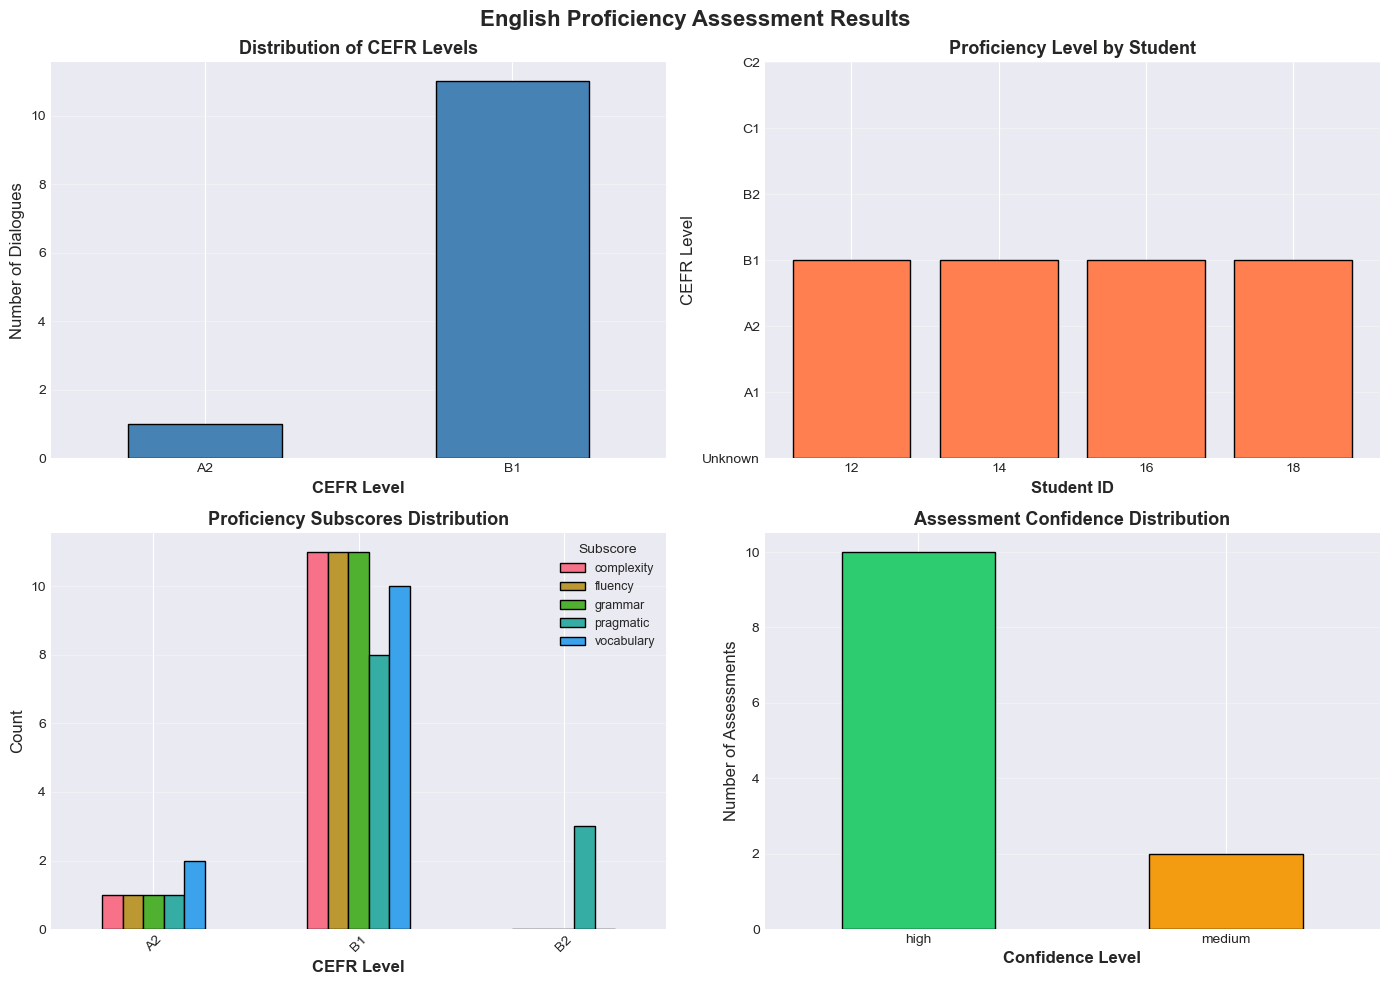

In [ ]:
# Visualization: Proficiency levels
if len(df_proficiency) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('English Proficiency Assessment Results', fontsize=16, fontweight='bold')
    
    # 1. CEFR Level Distribution
    cefr_counts = df_proficiency['cefr_level'].value_counts().sort_index()
    cefr_counts.plot(kind='bar', ax=axes[0, 0], color='steelblue', edgecolor='black')
    axes[0, 0].set_xlabel('CEFR Level', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Dialogues', fontsize=12)
    axes[0, 0].set_title('Distribution of CEFR Levels', fontsize=13, fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=0)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Proficiency by Student
    if 'student_id' in df_proficiency.columns:
        student_levels = df_proficiency.groupby('student_id')['cefr_level'].apply(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
        )
        # Convert CEFR levels to numeric for plotting
        cefr_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6, 'Unknown': 0}
        student_levels_numeric = student_levels.map(cefr_to_num).fillna(0).astype(int)
        
        # Plot using matplotlib directly to avoid pandas plotting issues
        axes[0, 1].bar(student_levels_numeric.index.astype(str), student_levels_numeric.values, 
                      color='coral', edgecolor='black')
        axes[0, 1].set_xlabel('Student ID', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('CEFR Level', fontsize=12)
        axes[0, 1].set_title('Proficiency Level by Student', fontsize=13, fontweight='bold')
        axes[0, 1].set_yticks(range(0, 7))
        axes[0, 1].set_yticklabels(['Unknown', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
        axes[0, 1].tick_params(axis='x', rotation=0)
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Subscore Distribution
    subscores = ['grammar', 'vocabulary', 'fluency', 'complexity', 'pragmatic']
    subscore_data = []
    for score in subscores:
        if score in df_proficiency.columns:
            counts = df_proficiency[score].value_counts()
            for level, count in counts.items():
                subscore_data.append({'subscore': score, 'level': level, 'count': count})
    
    if subscore_data:
        df_subscores = pd.DataFrame(subscore_data)
        subscore_pivot = df_subscores.pivot(index='level', columns='subscore', values='count').fillna(0)
        subscore_pivot.plot(kind='bar', ax=axes[1, 0], edgecolor='black')
        axes[1, 0].set_xlabel('CEFR Level', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('Count', fontsize=12)
        axes[1, 0].set_title('Proficiency Subscores Distribution', fontsize=13, fontweight='bold')
        axes[1, 0].legend(title='Subscore', fontsize=9)
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Confidence Distribution
    confidence_counts = df_proficiency['confidence'].value_counts()
    colors_conf = {'high': '#2ecc71', 'medium': '#f39c12', 'low': '#e74c3c'}
    conf_colors = [colors_conf.get(c, '#95a5a6') for c in confidence_counts.index]
    confidence_counts.plot(kind='bar', ax=axes[1, 1], color=conf_colors, edgecolor='black')
    axes[1, 1].set_xlabel('Confidence Level', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Assessments', fontsize=12)
    axes[1, 1].set_title('Assessment Confidence Distribution', fontsize=13, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=0)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_dir / '05_proficiency_assessment.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {output_dir / '05_proficiency_assessment.png'}")
    plt.show()
else:
    print("No proficiency data available for visualization.")


CORRELATION: PROFICIENCY vs REPAIR PATTERNS
num_repairs            0.268
num_turns              0.185
mean_words_per_turn    0.029
unresolved_count         NaN
li_count               0.160
bi_count               0.217
Name: proficiency_numeric, dtype: float64

Saved: ..\statistical_analysis_images\06_proficiency_correlations.png


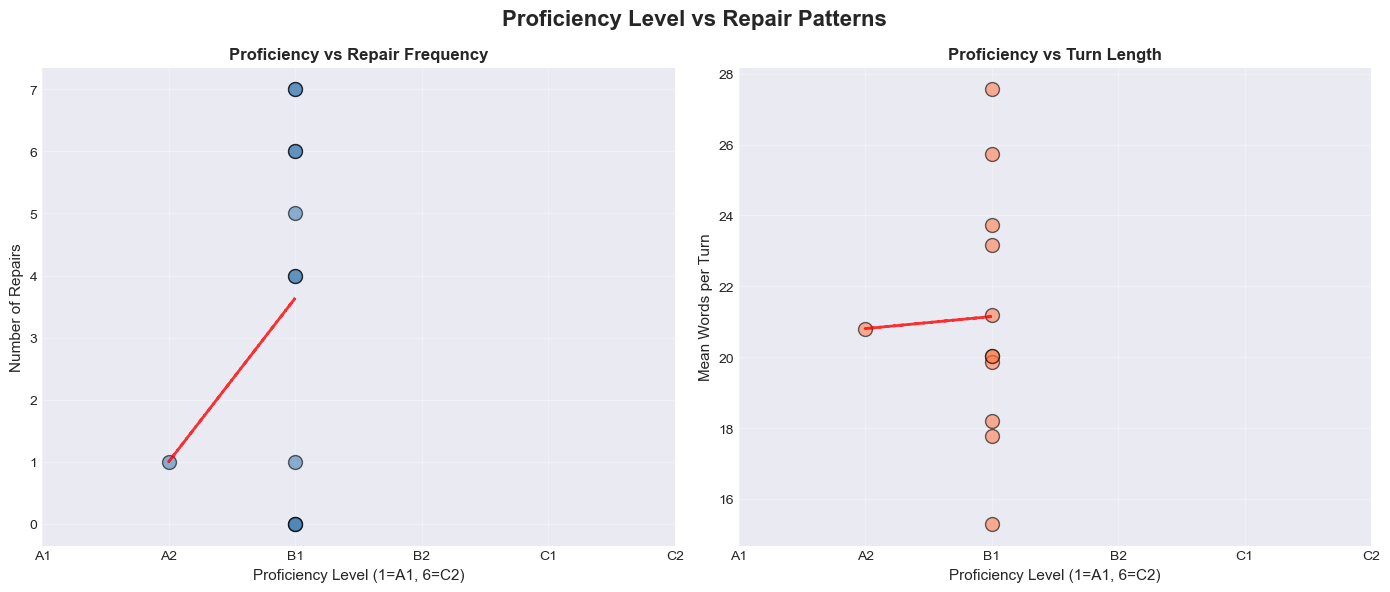

Correlation matrix saved to: ..\statistical_analysis_images\proficiency_correlations.csv


In [ ]:
# Correlation: Proficiency vs Repair Patterns
if len(df_proficiency) > 0 and 'df_dialogues_with_proficiency' in locals():
    # Merge proficiency with dialogue statistics
    df_merged = df_dialogues_with_proficiency.copy()
    
    # Convert CEFR to numeric for correlation
    cefr_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
    df_merged['proficiency_numeric'] = df_merged['cefr_level'].map(cefr_to_num)
    
    # Calculate correlations
    if 'proficiency_numeric' in df_merged.columns:
        corr_vars = ['proficiency_numeric', 'num_repairs', 'num_turns', 'mean_words_per_turn', 
                    'unresolved_count', 'li_count', 'bi_count']
        available_vars = [v for v in corr_vars if v in df_merged.columns]
        
        if len(available_vars) > 1:
            proficiency_corr = df_merged[available_vars].corr()['proficiency_numeric'].drop('proficiency_numeric')
            
            print("="*60)
            print("CORRELATION: PROFICIENCY vs REPAIR PATTERNS")
            print("="*60)
            print(proficiency_corr.round(3))
            
            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            fig.suptitle('Proficiency Level vs Repair Patterns', fontsize=16, fontweight='bold')
            
            # 1. Proficiency vs Number of Repairs
            if 'num_repairs' in df_merged.columns:
                axes[0].scatter(df_merged['proficiency_numeric'], df_merged['num_repairs'], 
                               alpha=0.6, s=100, color='steelblue', edgecolors='black')
                z = np.polyfit(df_merged['proficiency_numeric'].dropna(), 
                              df_merged['num_repairs'].dropna(), 1)
                p = np.poly1d(z)
                axes[0].plot(df_merged['proficiency_numeric'], 
                            p(df_merged['proficiency_numeric']), 
                            "r--", alpha=0.8, linewidth=2)
                axes[0].set_xlabel('Proficiency Level (1=A1, 6=C2)', fontsize=11)
                axes[0].set_ylabel('Number of Repairs', fontsize=11)
                axes[0].set_title('Proficiency vs Repair Frequency', fontsize=12, fontweight='bold')
                axes[0].set_xticks(range(1, 7))
                axes[0].set_xticklabels(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
                axes[0].grid(True, alpha=0.3)
            
            # 2. Proficiency vs Mean Words per Turn
            if 'mean_words_per_turn' in df_merged.columns:
                axes[1].scatter(df_merged['proficiency_numeric'], df_merged['mean_words_per_turn'], 
                               alpha=0.6, s=100, color='coral', edgecolors='black')
                z = np.polyfit(df_merged['proficiency_numeric'].dropna(), 
                              df_merged['mean_words_per_turn'].dropna(), 1)
                p = np.poly1d(z)
                axes[1].plot(df_merged['proficiency_numeric'], 
                            p(df_merged['proficiency_numeric']), 
                            "r--", alpha=0.8, linewidth=2)
                axes[1].set_xlabel('Proficiency Level (1=A1, 6=C2)', fontsize=11)
                axes[1].set_ylabel('Mean Words per Turn', fontsize=11)
                axes[1].set_title('Proficiency vs Turn Length', fontsize=12, fontweight='bold')
                axes[1].set_xticks(range(1, 7))
                axes[1].set_xticklabels(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])
                axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(output_dir / '06_proficiency_correlations.png', dpi=300, bbox_inches='tight')
            print(f"\nSaved: {output_dir / '06_proficiency_correlations.png'}")
            plt.show()
            
            # Save correlation matrix
            corr_matrix = df_merged[available_vars].corr()
            corr_matrix.to_csv(output_dir / 'proficiency_correlations.csv')
            print(f"Correlation matrix saved to: {output_dir / 'proficiency_correlations.csv'}")
else:
    print("Proficiency data not available for correlation analysis.")


## 8. Summary Statistics Report

Generate a comprehensive summary report of all analyses.



In [ ]:
# Generate comprehensive summary report
# Calculate values first to avoid errors in f-string
total_dialogues = len(df_dialogues)
total_repairs = len(df_repairs)
num_students = df_dialogues['student_id'].nunique()
num_weeks = df_dialogues['week'].nunique()

# Add proficiency summary if available
proficiency_summary = ""
try:
    if 'df_proficiency' in locals() and len(df_proficiency) > 0:
        student_agg_str = ""
        if 'student_aggregated' in locals():
            try:
                student_agg_str = student_aggregated[['average_level', 'confidence']].to_string()
            except:
                student_agg_str = "N/A"
        else:
            student_agg_str = "N/A"
        
        proficiency_summary = f"""

ENGLISH PROFICIENCY ASSESSMENT
-------------------------------
Total Dialogues Assessed: {len(df_proficiency)}
CEFR Level Distribution:
{df_proficiency['cefr_level'].value_counts().sort_index().to_string()}

Average Proficiency by Student:
{student_agg_str}
"""
    else:
        proficiency_summary = "\nENGLISH PROFICIENCY ASSESSMENT\n-------------------------------\nNot assessed in this run.\n"
except:
    proficiency_summary = "\nENGLISH PROFICIENCY ASSESSMENT\n-------------------------------\nNot assessed in this run.\n"

mean_repairs = df_dialogues['num_repairs'].mean()
sd_repairs = df_dialogues['num_repairs'].std()
median_repairs = df_dialogues['num_repairs'].median()
min_repairs = df_dialogues['num_repairs'].min()
max_repairs = df_dialogues['num_repairs'].max()

mean_turns = df_dialogues['num_turns'].mean()
sd_turns = df_dialogues['num_turns'].std()
median_turns = df_dialogues['num_turns'].median()

mean_words = df_dialogues['mean_words_per_turn'].mean()
mean_learner_words_val = df_dialogues['mean_learner_words'].mean()
mean_bot_words_val = df_dialogues['mean_bot_words'].mean()

li_count = len(df_repairs[df_repairs['initiation'] == 'LI'])
bi_count = len(df_repairs[df_repairs['initiation'] == 'BI'])
li_pct = (li_count / total_repairs * 100) if total_repairs > 0 else 0
bi_pct = (bi_count / total_repairs * 100) if total_repairs > 0 else 0

r_count = len(df_repairs[df_repairs['resolution'] == 'R'])
ua_count = len(df_repairs[df_repairs['resolution'] == 'U-A'])
up_count = len(df_repairs[df_repairs['resolution'] == 'U-P'])
r_pct = (r_count / total_repairs * 100) if total_repairs > 0 else 0
ua_pct = (ua_count / total_repairs * 100) if total_repairs > 0 else 0
up_pct = (up_count / total_repairs * 100) if total_repairs > 0 else 0

summary_report = f"""
================================================================================
STATISTICAL ANALYSIS SUMMARY REPORT
Repair Patterns in Learner-AI Interaction
================================================================================

DATASET OVERVIEW
----------------
Total Dialogues: {total_dialogues}
Total Repair Sequences: {total_repairs}
Students: {num_students}
Weeks: {num_weeks}

DESCRIPTIVE STATISTICS
----------------------
Mean Repairs per Session: {mean_repairs:.2f} (SD = {sd_repairs:.2f})
Median Repairs per Session: {median_repairs:.2f}
Range: {min_repairs} - {max_repairs}

Mean Turns per Dialogue: {mean_turns:.2f} (SD = {sd_turns:.2f})
Median Turns per Dialogue: {median_turns:.2f}

Mean Words per Turn: {mean_words:.2f}
Mean Learner Words per Turn: {mean_learner_words_val:.2f}
Mean Bot Words per Turn: {mean_bot_words_val:.2f}

REPAIR PATTERNS: INITIATION
---------------------------
Learner-Initiated (LI): {li_count} ({li_pct:.1f}%)
Bot-Initiated (BI): {bi_count} ({bi_pct:.1f}%)

REPAIR PATTERNS: RESOLUTION
----------------------------
Resolved (R): {r_count} ({r_pct:.1f}%)
Unresolved-Abandoned (U-A): {ua_count} ({ua_pct:.1f}%)
Unresolved-Persists (U-P): {up_count} ({up_pct:.1f}%)

CHI-SQUARE TEST: Initiation × Resolution
----------------------------------------
Chi-square statistic: {chi2:.4f}
Degrees of freedom: {dof}
P-value: {p_value:.4f}
Test Performed: {'Yes' if dof > 0 else 'No (insufficient categories)'}
Significant: {'Yes' if (dof > 0 and p_value < 0.05) else 'No'} (α = 0.05)

CORRELATIONS
------------
Repair Frequency × Number of Turns: r = {corr_repairs_turns:.3f} (p = {p1:.3f})
Repair Frequency × Mean Words per Turn: r = {corr_repairs_words:.3f} (p = {p2:.3f})
Unresolved Repairs × Number of Turns: r = {corr_unresolved_turns:.3f} (p = {p3:.3f})

TOP TRIGGER CATEGORIES
----------------------
{trigger_category_counts.head(5).to_string()}
{proficiency_summary}
================================================================================
Note: Satisfaction scores and ease ratings are not available in the current dataset.
When available, additional correlations will be calculated:
- Repair frequency × satisfaction
- Unresolved repairs × ease ratings
- Turns × satisfaction
================================================================================
"""

print(summary_report)

# Save report to file
with open(output_dir / 'summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"\nFull report saved to: {output_dir / 'summary_report.txt'}")




STATISTICAL ANALYSIS SUMMARY REPORT
Repair Patterns in Learner-AI Interaction

DATASET OVERVIEW
----------------
Total Dialogues: 12
Total Repair Sequences: 41
Students: 4
Weeks: 4

DESCRIPTIVE STATISTICS
----------------------
Mean Repairs per Session: 3.42 (SD = 2.84)
Median Repairs per Session: 4.00
Range: 0 - 7

Mean Turns per Dialogue: 48.25 (SD = 20.83)
Median Turns per Dialogue: 45.00

Mean Words per Turn: 21.12
Mean Learner Words per Turn: 11.07
Mean Bot Words per Turn: 29.88

REPAIR PATTERNS: INITIATION
---------------------------
Learner-Initiated (LI): 26 (63.4%)
Bot-Initiated (BI): 15 (36.6%)

REPAIR PATTERNS: RESOLUTION
----------------------------
Resolved (R): 41 (100.0%)
Unresolved-Abandoned (U-A): 0 (0.0%)
Unresolved-Persists (U-P): 0 (0.0%)

CHI-SQUARE TEST: Initiation × Resolution
----------------------------------------
Chi-square statistic: 0.0000
Degrees of freedom: 0
P-value: 1.0000
Test Performed: No (insufficient categories)
Significant: No (α = 0.05)

CORRELA

## LLM Validation Performance Report

Generate performance metrics and visualization for LLM repair detection validation.

LLM REPAIR DETECTION - VALIDATION PERFORMANCE REPORT

Total Dialogues Processed: 206
Total Repairs Detected: 229
Valid Repairs: 229
Invalid Repairs: 0

Repair Accuracy Rate: 100.00%
Dialogue Coverage: 100.00%
Files with Critical Issues: 0
Files with Warnings: 118

✅ EXCELLENT: All repairs validated successfully!
✅ No critical errors detected.
✅ 100% repair accuracy achieved.

✅ Performance report saved to: ..\statistical_analysis_images\llm_validation_performance_report.png


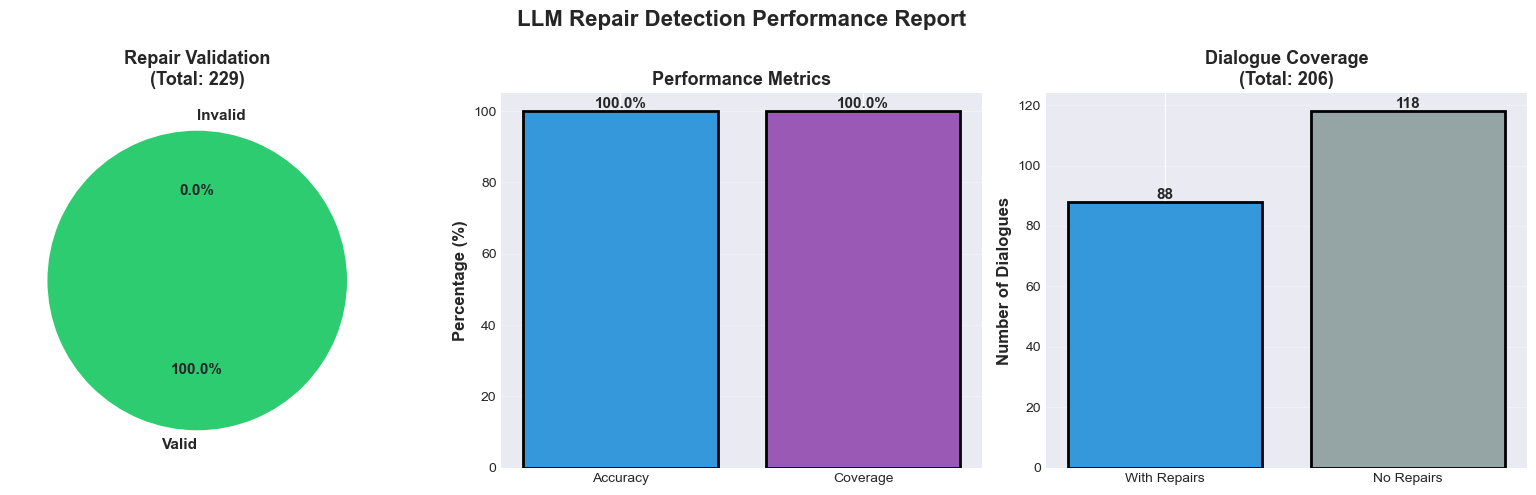

In [27]:
# Load validation report
import json
from pathlib import Path

validation_path = Path('../data/repairs/VALIDATION_REPORT.json')
if not validation_path.exists():
    validation_path = Path('data/repairs/VALIDATION_REPORT.json')

with open(validation_path, 'r', encoding='utf-8') as f:
    validation_data = json.load(f)

summary = validation_data['summary']

# Calculate metrics
total_repairs = summary['total_repairs']
valid_repairs = summary['valid_repairs']
invalid_repairs = summary['invalid_repairs']
total_dialogues = summary['total_dialogues']
dialogues_with_repairs = summary['with_repairs']

# Success rates
repair_accuracy = (valid_repairs / total_repairs * 100) if total_repairs > 0 else 100
dialogue_coverage = (summary['with_repair_files'] / total_dialogues * 100) if total_dialogues > 0 else 100

print('='*60)
print('LLM REPAIR DETECTION - VALIDATION PERFORMANCE REPORT')
print('='*60)
print(f'\nTotal Dialogues Processed: {total_dialogues}')
print(f'Total Repairs Detected: {total_repairs}')
print(f'Valid Repairs: {valid_repairs}')
print(f'Invalid Repairs: {invalid_repairs}')
print(f'\nRepair Accuracy Rate: {repair_accuracy:.2f}%')
print(f'Dialogue Coverage: {dialogue_coverage:.2f}%')
print(f'Files with Critical Issues: {summary["files_with_issues"]}')
print(f'Files with Warnings: {summary["files_with_warnings"]}')

if invalid_repairs == 0:
    print('\n✅ EXCELLENT: All repairs validated successfully!')
    print('✅ No critical errors detected.')
    print('✅ 100% repair accuracy achieved.')
else:
    print(f'\n⚠️  {invalid_repairs} invalid repairs detected.')
    print(f'⚠️  {summary["files_with_issues"]} files with critical issues.')

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('LLM Repair Detection Performance Report', fontsize=16, fontweight='bold')

# 1. Repair Accuracy
ax1 = axes[0]
repair_data = [valid_repairs, invalid_repairs]
labels = ['Valid', 'Invalid']
colors_pie = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax1.pie(repair_data, labels=labels, colors=colors_pie,
                                   autopct='%1.1f%%', startangle=90,
                                   textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title(f'Repair Validation\n(Total: {total_repairs})', fontsize=13, fontweight='bold')

# 2. Performance Metrics
ax2 = axes[1]
metrics = ['Accuracy', 'Coverage']
values = [repair_accuracy, dialogue_coverage]
bars = ax2.bar(metrics, values, color=['#3498db', '#9b59b6'], edgecolor='black', linewidth=2)
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Performance Metrics', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Dialogue Coverage
ax3 = axes[2]
dialogue_data = [dialogues_with_repairs, summary['without_repairs']]
labels_dialogue = ['With Repairs', 'No Repairs']
bars3 = ax3.bar(labels_dialogue, dialogue_data, color=['#3498db', '#95a5a6'],
                edgecolor='black', linewidth=2)
ax3.set_ylabel('Number of Dialogues', fontsize=12, fontweight='bold')
ax3.set_title(f'Dialogue Coverage\n(Total: {total_dialogues})', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'llm_validation_performance_report.png', dpi=300, bbox_inches='tight')
print(f'\n✅ Performance report saved to: {output_dir / "llm_validation_performance_report.png"}')
plt.show()
